<a href="https://colab.research.google.com/github/MuhametshaKakayev/PneumaniaInceptionV3/blob/main/Guncel_Phenmon%C4%B1aXray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!rm -rf /content/*

In [2]:
# 1. Kaggle API’yı kur
!pip install --quiet kaggle

# 2. Kaggle JSON dosyanı doğru yere kopyala
import os
os.makedirs(os.path.expanduser('~/.kaggle'), exist_ok=True)
os.replace('/content/kaggle(1).json', os.path.expanduser('~/.kaggle/kaggle.json'))
os.chmod(os.path.expanduser('~/.kaggle/kaggle.json'),0o600)

# 3. Veri setini indir ve aç
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p /content --unzip

# 4. Ana klasör yolunu belirt ve yapıyı göster
base_dir = '/content/chest_xray'
print("Klasör yapısı:")
!find $base_dir -maxdepth 2 -type d

# 5. TÜM veri setini (örneklemeden) yeni klasöre kopyala
import shutil

full_dir = '/content/chest_xray_full'

for split in ['train', 'val', 'test']:
    for cls in ['NORMAL', 'PNEUMONIA']:
        src = os.path.join(base_dir, split, cls)
        dst = os.path.join(full_dir, split, cls)
        os.makedirs(dst, exist_ok=True)

        files = os.listdir(src)
        for f in files:
            shutil.copy(os.path.join(src, f), os.path.join(dst, f))

print("Tüm veri seti başarıyla kopyalandı:", full_dir)



Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.26G/2.29G [00:28<00:00, 38.3MB/s]
100% 2.29G/2.29G [00:28<00:00, 85.9MB/s]
Klasör yapısı:
/content/chest_xray
/content/chest_xray/test
/content/chest_xray/test/PNEUMONIA
/content/chest_xray/test/NORMAL
/content/chest_xray/__MACOSX
/content/chest_xray/__MACOSX/chest_xray
/content/chest_xray/train
/content/chest_xray/train/PNEUMONIA
/content/chest_xray/train/NORMAL
/content/chest_xray/chest_xray
/content/chest_xray/chest_xray/test
/content/chest_xray/chest_xray/train
/content/chest_xray/chest_xray/val
/content/chest_xray/val
/content/chest_xray/val/PNEUMONIA
/content/chest_xray/val/NORMAL
Tüm veri seti başarıyla kopyalandı: /content/chest_xray_full


In [3]:
import os
import math
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import random
import shutil

# Veri dizinleri ve sınıf isimleri
full_dir = '/content/chest_xray_full'
splits = ['train', 'val', 'test']
classes = ['NORMAL', 'PNEUMONIA']

print(">>> ORİJİNAL (full) KLASÖR GÖRSEL SAYILARI:\n")
print(f"{'Set':<10}{'Sınıf':<12}{'Görüntü Sayısı':>16}")
print("-" * 38)

for split in splits:
    for cls in classes:
        path = os.path.join(full_dir, split, cls)
        if os.path.exists(path):
            count = len([
                f for f in os.listdir(path)
                if os.path.isfile(os.path.join(path, f)) and f.lower().endswith(('.jpeg', '.jpg', '.png'))
            ])
            print(f"{split:<10}{cls:<12}{count:>16}")
        else:
            print(f"{split:<10}{cls:<12}{'Klasör Yok':>16}")


full_dir = '/content/chest_xray_full'
# Klasör içeriğini say ve yazdır
splits = ['train', 'val', 'test']
classes = ['NORMAL', 'PNEUMONIA']
balanced_dir = '/content/chest_xray_balanced'

val_split_ratio = 0.15  # %15 validation ayır

# Klasörleri hazırla
for split in ['train', 'val', 'test']:
    for cls in ['NORMAL', 'PNEUMONIA']:
        os.makedirs(os.path.join(balanced_dir, split, cls), exist_ok=True)

# Test ve orijinal val klasörünü olduğu gibi kopyala
for split in ['val', 'test']:
    for cls in ['NORMAL', 'PNEUMONIA']:
        src = os.path.join(full_dir, split, cls)
        dst = os.path.join(balanced_dir, split, cls)
        for f in os.listdir(src):
            shutil.copy2(os.path.join(src, f), os.path.join(dst, f))

# Train içinden validation ayır ve train setini dengele
normal_train_files = []
pneumonia_train_files = []

for cls in ['NORMAL', 'PNEUMONIA']:
    src_train = os.path.join(full_dir, 'train', cls)
    files = os.listdir(src_train)
    random.shuffle(files)

    val_count = int(len(files) * val_split_ratio)
    val_files = files[:val_count]
    train_files = files[val_count:]

    # Validation dosyalarını kopyala
    for f in val_files:
        shutil.copy2(os.path.join(src_train, f), os.path.join(balanced_dir, 'val', cls, f))

    # Train dosyalarını listele (daha sonra dengeleme için)
    if cls == 'NORMAL':
        normal_train_files = train_files
    else:
        pneumonia_train_files = train_files

# Validation setini dengele
normal_val_path = os.path.join(balanced_dir, 'val', 'NORMAL')
pneumonia_val_path = os.path.join(balanced_dir, 'val', 'PNEUMONIA')

normal_val_files = os.listdir(normal_val_path)
pneumonia_val_files = os.listdir(pneumonia_val_path)

# PNEUMONIA sayısını NORMAL sayısına indir
pneumonia_val_sample = random.sample(pneumonia_val_files, min(len(pneumonia_val_files), len(normal_val_files)))

# Fazla validation dosyalarını sil
for f in pneumonia_val_files:
    if f not in pneumonia_val_sample:
        os.remove(os.path.join(pneumonia_val_path, f))

print("Validation seti dengelendi.")

# Train setini dengele: PNEUMONIA sayısını NORMAL sayısına indir
pneumonia_train_sample = random.sample(pneumonia_train_files, min(len(pneumonia_train_files), len(normal_train_files)))

# Train dosyalarını kopyala
for f in normal_train_files:
    shutil.copy2(os.path.join(full_dir, 'train', 'NORMAL', f), os.path.join(balanced_dir, 'train', 'NORMAL', f))

for f in pneumonia_train_sample:
    shutil.copy2(os.path.join(full_dir, 'train', 'PNEUMONIA', f), os.path.join(balanced_dir, 'train', 'PNEUMONIA', f))

print("Train seti dengelendi, validation ayrıldı ve yeni klasöre kopyalandı:", balanced_dir)

# Test setini dengele
normal_test_path = os.path.join(balanced_dir, 'test', 'NORMAL')
pneumonia_test_path = os.path.join(balanced_dir, 'test', 'PNEUMONIA')

normal_test_files = os.listdir(normal_test_path)
pneumonia_test_files = os.listdir(pneumonia_test_path)

# PNEUMONIA sayısını NORMAL sayısına eşitle
if len(pneumonia_test_files) > len(normal_test_files):
    pneumonia_test_sample = random.sample(pneumonia_test_files, len(normal_test_files))
    # Fazla PNEUMONIA test dosyalarını sil
    for f in pneumonia_test_files:
        if f not in pneumonia_test_sample:
            os.remove(os.path.join(pneumonia_test_path, f))
    print(f"Test seti dengelendi: PNEUMONIA görüntü sayısı {len(normal_test_files)}'e indirildi.")
else:
    print("Test seti zaten dengeli veya PNEUMONIA daha az.")

# Klasör içeriğini say ve yazdır
splits = ['train', 'val', 'test']
classes = ['NORMAL', 'PNEUMONIA']

for split in splits:
    print(f"\n--- {split.upper()} ---")
    for cls in classes:
        path = os.path.join(balanced_dir, split, cls)
        if os.path.exists(path):
            count = len([f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))])
            print(f"{cls}: {count} görüntü")
        else:
            print(f"{cls}: klasör bulunamadı")


>>> ORİJİNAL (full) KLASÖR GÖRSEL SAYILARI:

Set       Sınıf         Görüntü Sayısı
--------------------------------------
train     NORMAL                  1341
train     PNEUMONIA               3875
val       NORMAL                     8
val       PNEUMONIA                  8
test      NORMAL                   234
test      PNEUMONIA                390
Validation seti dengelendi.
Train seti dengelendi, validation ayrıldı ve yeni klasöre kopyalandı: /content/chest_xray_balanced
Test seti dengelendi: PNEUMONIA görüntü sayısı 234'e indirildi.

--- TRAIN ---
NORMAL: 1140 görüntü
PNEUMONIA: 1140 görüntü

--- VAL ---
NORMAL: 209 görüntü
PNEUMONIA: 209 görüntü

--- TEST ---
NORMAL: 234 görüntü
PNEUMONIA: 234 görüntü


In [30]:
from tensorflow.keras.applications import InceptionV3, ResNet50V2
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1. ImageDataGenerator
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

# 2. DataLoader
train_it = train_gen.flow_from_directory(
    '/content/chest_xray_balanced/train',
    target_size=(299, 299),
    batch_size=16,
    class_mode='binary'
)

val_it = val_gen.flow_from_directory(
    '/content/chest_xray_balanced/val',
    target_size=(299, 299),
    batch_size=16,
    class_mode='binary'
)

test_it = test_gen.flow_from_directory(
    '/content/chest_xray_balanced/test',
    target_size=(299, 299),
    batch_size=16,
    class_mode='binary',
    shuffle=False
)

# 1. Ortak Giriş Katmanı
input_tensor = Input(shape=(299, 299, 3))

# 2. Modeller
inception_base = InceptionV3(weights='imagenet', include_top=False, input_tensor=input_tensor)
resnet_base = ResNet50V2(weights='imagenet', include_top=False, input_tensor=input_tensor)

# 3. Özellik çıkarımı
inception_features = GlobalAveragePooling2D()(inception_base.output)
resnet_features = GlobalAveragePooling2D()(resnet_base.output)

# 4. Özellikleri birleştir
merged = concatenate([inception_features, resnet_features])

# 5. Fully connected katmanlar
x = Dropout(0.5)(merged)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_tensor, outputs=output)

# 6. Katmanları dondur (önceki öğrenmeyi koru)
for layer in inception_base.layers[:-40]:
    layer.trainable = False
for layer in resnet_base.layers[:-40]:
    layer.trainable = False

# 7. Derleme
model.compile(optimizer=Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_accuracy', mode='max')
earlystop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=1e-6, verbose=1)

history = model.fit(
    train_it,
    epochs=10,
    steps_per_epoch=train_it.samples // train_it.batch_size,
    validation_data=val_it,
    validation_steps=val_it.samples // val_it.batch_size,
    callbacks=[checkpoint, earlystop, reduce_lr]
)

# Test sonuçlarını al
y_true = test_it.classes
y_prob = model.predict(test_it).ravel()

from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix

# ROC Threshold seçimi
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
optimal_idx = (tpr - fpr).argmax()
optimal_threshold = thresholds[optimal_idx]
y_pred = (y_prob > optimal_threshold).astype(int)

# Metrikler
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp+fp) else 0
recall = tp / (tp + fn) if (tp+fn) else 0
specificity = tn / (tn + fp) if (tn+fp) else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) else 0
roc_auc = auc(fpr, tpr)

print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=['NORMAL','PNEUMONIA']))
print(f"Accuracy:    {accuracy:.4f}")
print(f"Precision:   {precision:.4f}")
print(f"Recall:      {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1 Score:    {f1:.4f}")
print(f"AUC Score:   {roc_auc:.4f}")



Found 2280 images belonging to 2 classes.
Found 418 images belonging to 2 classes.
Found 468 images belonging to 2 classes.


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 305, 305,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 150, 150,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 152, 152,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 75, 75,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 75, 75,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 75, 75,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 75, 75,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 75, 75,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 75, 75,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 77, 77,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 75, 75,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 75, 75,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 75, 75,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 75, 75,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 75, 75,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 75, 75,    │          0 │ conv2_block1_0_c

 Total params: 45,900,321 (175.10 MB)

 Trainable params: 21,840,513 (83.31 MB)

 Non-trainable params: 24,059,808 (91.78 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 637ms/step - accuracy: 0.7079 - loss: 0.5763

142/142 ━━━━━━━━━━━━━━━━━━━━ 148s 779ms/step - accuracy: 0.7085 - loss: 0.5757 - val_accuracy: 0.8462 - val_loss: 0.3583 - learning_rate: 1.0000e-05
Epoch 2/10
  1/142 ━━━━━━━━━━━━━━━━━━━━ 32s 230ms/step - accuracy: 0.8125 - loss: 0.5133

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


142/142 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.8125 - loss: 0.5133 - val_accuracy: 0.8462 - val_loss: 0.3577 - learning_rate: 1.0000e-05
Epoch 3/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - accuracy: 0.9053 - loss: 0.2993

142/142 ━━━━━━━━━━━━━━━━━━━━ 88s 621ms/step - accuracy: 0.9053 - loss: 0.2991 - val_accuracy: 0.9183 - val_loss: 0.2394 - learning_rate: 1.0000e-05
Epoch 4/10
  1/142 ━━━━━━━━━━━━━━━━━━━━ 31s 226ms/step - accuracy: 0.9375 - loss: 0.1328

142/142 ━━━━━━━━━━━━━━━━━━━━ 21s 145ms/step - accuracy: 0.9375 - loss: 0.1328 - val_accuracy: 0.9207 - val_loss: 0.2370 - learning_rate: 1.0000e-05
Epoch 5/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.9145 - loss: 0.2297

142/142 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.9146 - loss: 0.2295 - val_accuracy: 0.9399 - val_loss: 0.1758 - learning_rate: 1.0000e-05
Epoch 6/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 12s 80ms/step - accuracy: 1.0000 - loss: 0.0892 - val_accuracy: 0.9399 - val_loss: 0.1757 - learning_rate: 1.0000e-05
Epoch 7/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 541ms/step - accuracy: 0.9284 - loss: 0.1855

142/142 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - accuracy: 0.9284 - loss: 0.1854 - val_accuracy: 0.9519 - val_loss: 0.1270 - learning_rate: 1.0000e-05
Epoch 8/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - accuracy: 1.0000 - loss: 0.0766 - val_accuracy: 0.9519 - val_loss: 0.1273 - learning_rate: 1.0000e-05
Epoch 9/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 536ms/step - accuracy: 0.9533 - loss: 0.1349

142/142 ━━━━━━━━━━━━━━━━━━━━ 149s 771ms/step - accuracy: 0.9532 - loss: 0.1350 - val_accuracy: 0.9639 - val_loss: 0.0973 - learning_rate: 1.0000e-05
Epoch 10/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 1.0000 - loss: 0.0244 - val_accuracy: 0.9639 - val_loss: 0.0986 - learning_rate: 1.0000e-05
30/30 ━━━━━━━━━━━━━━━━━━━━ 25s 554ms/step

Confusion Matrix:
 [[216  18]
 [ 18 216]]

Classification Report:
               precision    recall  f1-score   support

      NORMAL       0.92      0.92      0.92       234
   PNEUMONIA       0.92      0.92      0.92       234

    accuracy                           0.92       468
   macro avg       0.92      0.92      0.92       468
weighted avg       0.92      0.92      0.92       468

Accuracy:    0.9231
Precision:   0.9231
Recall:      0.9231
Specificity: 0.9231
F1 Score:    0.9231
AUC Score:   0.9754


Seçilen test görüntüsü: /content/chest_xray_balanced/test/PNEUMONIA/person11_virus_38.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
Tahmin: PNEUMONIA (%97.21 kesinlik)
Gerçek sınıf: PNEUMONIA


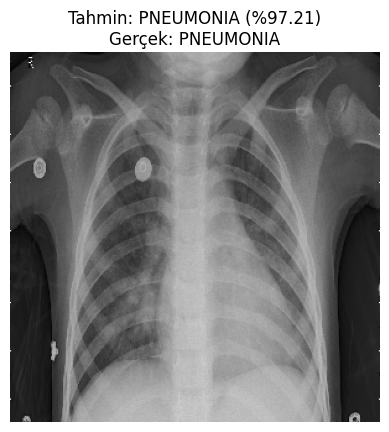

Model çıkış şekli: (None, 1)


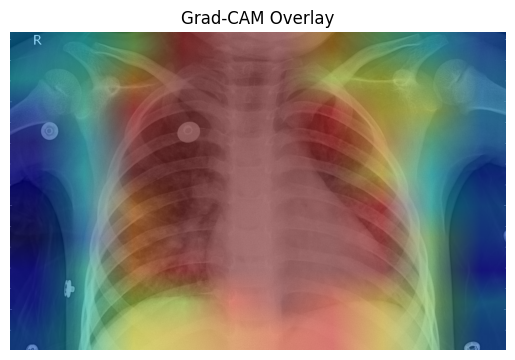

In [31]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt



# Test klasörleri
test_pneumonia_dir = '/content/chest_xray_balanced/test/PNEUMONIA'
test_normal_dir = '/content/chest_xray_balanced/test/NORMAL'

# Tüm test görüntülerini topla
all_test_files = []
for cls_dir in [test_pneumonia_dir, test_normal_dir]:
    files = [os.path.join(cls_dir, f) for f in os.listdir(cls_dir) if f.lower().endswith(('.jpeg', '.jpg', '.png'))]
    all_test_files.extend(files)

# Rastgele bir test görüntüsü seç
img_path = random.choice(all_test_files)
print(f"Seçilen test görüntüsü: {img_path}")

# Görüntüyü yükle ve ön işle
img = image.load_img(img_path, target_size=(299, 299))
img_array = image.img_to_array(img)
img_array_for_display = img_array.astype('uint8')  # Görüntü gösterim için (0-255 aralığında)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Tahmin yap
preds = model.predict(img_array)
prob = preds[0][0]
label = "PNEUMONIA" if prob > 0.5 else "NORMAL"
confidence = prob if prob > 0.5 else 1 - prob
print(f"Tahmin: {label} (%{confidence*100:.2f} kesinlik)")

# Gerçek sınıfı yol isminden çıkar
actual_class = "PNEUMONIA" if "PNEUMONIA" in img_path else "NORMAL"
print(f"Gerçek sınıf: {actual_class}")

# Tahmin sonucunu göster
plt.imshow(img_array_for_display.astype('uint8'))
plt.axis('off')
plt.title(f"Tahmin: {label} (%{confidence*100:.2f})\nGerçek: {actual_class}")
plt.show()

print("Model çıkış şekli:", model.output_shape)



def save_and_display_gradcam(img_path, heatmap, cam_path="gradcam.jpg", alpha=0.4):
    # Orijinal resmi oku
    img = tf.keras.utils.load_img(img_path)
    img = tf.keras.utils.img_to_array(img)

    # Normalize ısı haritası
    heatmap = np.maximum(heatmap, 0)
    if np.max(heatmap) == 0:
        heatmap = np.zeros_like(heatmap)
    else:
        heatmap /= np.max(heatmap)

    # Isı haritasını 0-255 arası çevir ve renkli yap (jet colormap)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Isı haritasını orijinal resmin boyutuna getir
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Orijinal resmi uint8'e çevir
    img = np.uint8(img)

    # Bindirme (overlay)
    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)

    # Görüntüle
    plt.imshow(superimposed_img.astype("uint8"))
    plt.axis("off")
    plt.title("Grad-CAM Overlay")
    plt.show()

save_and_display_gradcam(img_path, heatmap)


Test edilecek görüntü: /content/test3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Tahmin: NORMAL (%81.52 kesinlik)


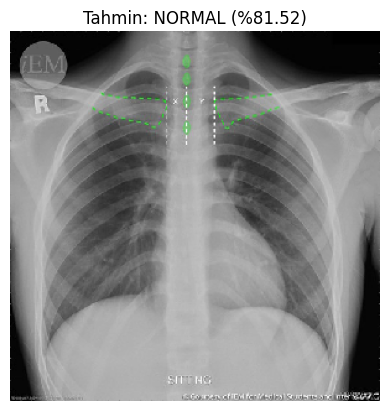

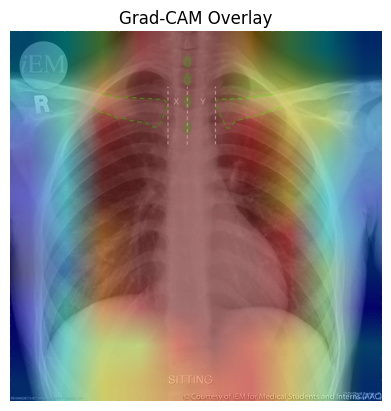

In [32]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input
import tensorflow as tf
import cv2

# Test edilecek görüntü yolu
img_path = '/content/test3.jpg'
print(f"Test edilecek görüntü: {img_path}")

# Görüntüyü yükle ve ön işle
img = image.load_img(img_path, target_size=(299, 299))
img_array = image.img_to_array(img)
img_array_for_display = img_array.astype('uint8')  # Görüntü gösterimi için
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Tahmin yap
preds = model.predict(img_array)
prob = preds[0][0]
label = "PNEUMONIA" if prob > 0.5 else "NORMAL"
confidence = prob if prob > 0.5 else 1 - prob
print(f"Tahmin: {label} (%{confidence*100:.2f} kesinlik)")

# Görüntüyü göster
plt.imshow(img_array_for_display)
plt.axis('off')
plt.title(f"Tahmin: {label} (%{confidence*100:.2f})")
plt.show()

def save_and_display_gradcam(img_path, heatmap, cam_path="gradcam.jpg", alpha=0.4):
    # Orijinal resmi oku
    img = tf.keras.utils.load_img(img_path)
    img = tf.keras.utils.img_to_array(img)

    # Normalize ısı haritası
    heatmap = np.maximum(heatmap, 0)
    if np.max(heatmap) == 0:
        heatmap = np.zeros_like(heatmap)
    else:
        heatmap /= np.max(heatmap)

    # Isı haritasını 0-255 arası çevir ve renkli yap (jet colormap)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Isı haritasını orijinal resmin boyutuna getir
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Orijinal resmi uint8'e çevir
    img = np.uint8(img)

    # Bindirme (overlay)
    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)

    # Görüntüle
    plt.imshow(superimposed_img.astype("uint8"))
    plt.axis("off")
    plt.title("Grad-CAM Overlay")
    plt.show()

save_and_display_gradcam(img_path, heatmap)